In [1]:
import numpy as np
import sacc
import matplotlib.pyplot as plt

# 1. Read data file
First, read one of the sacc files. We will be looking at the file containing the cross-correlations with masked X-ray point sources.

In [2]:
s = sacc.Sacc.load_fits('cls_cov_syx_masked_ngcov.fits')

# 2. Tracer information
We can get information about the different tracers (i.e. maps) for which power spectra have been estimated. Most importantly, the sacc file contains the redshift distributions of the different DES bins (which you need to interpret the $C_\ell$s within a given model).

ROSAT generic
Planck__tSZ15 cmb_tSZ
DESY3wl__0 galaxy_shear
DESY3wl__1 galaxy_shear
DESY3wl__2 galaxy_shear
DESY3wl__3 galaxy_shear


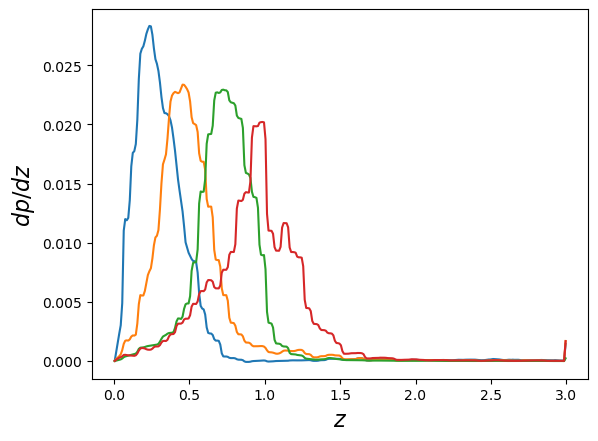

In [3]:
for name, t in s.tracers.items():
    print(name, t.quantity)

for ibin in range(4):
    t = s.tracers[f'DESY3wl__{ibin}']
    plt.plot(t.z, t.nz, '-', label=f'Bin {ibin+1}')
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$dp/dz$', fontsize=16);

# 3. Power spectrum information
You can now look look at all the power spectra in the sacc file. First, to see which spectra are available, run `s.get_tracer_combinations`.

You can see that we only include the different cross-correlations but no auto correlations or even cross-correlations between different cosmic shear bins.

In [4]:
for t1, t2, in s.get_tracer_combinations():
    print(t1, t2)

ROSAT Planck__tSZ15
Planck__tSZ15 DESY3wl__0
Planck__tSZ15 DESY3wl__1
Planck__tSZ15 DESY3wl__2
Planck__tSZ15 DESY3wl__3
ROSAT DESY3wl__0
ROSAT DESY3wl__1
ROSAT DESY3wl__2
ROSAT DESY3wl__3


## 3.1 Power spectrum measurements
To access the power spectrum measurements themselves, use `s.get_ell_cl`. The code above will get you the power spectra as well as the individual covariance matrix blocks, just so you can look at the error bars. To handle the full covariance matrix, read further.

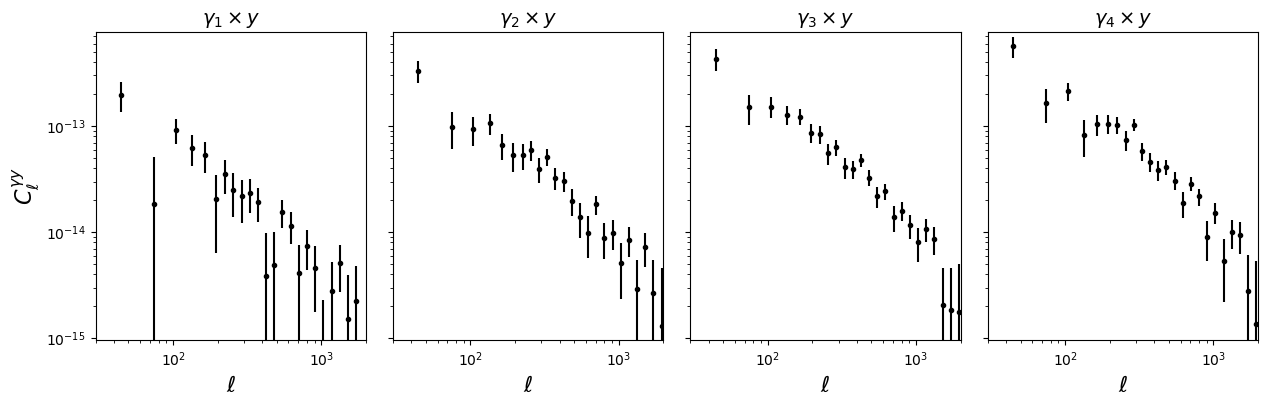

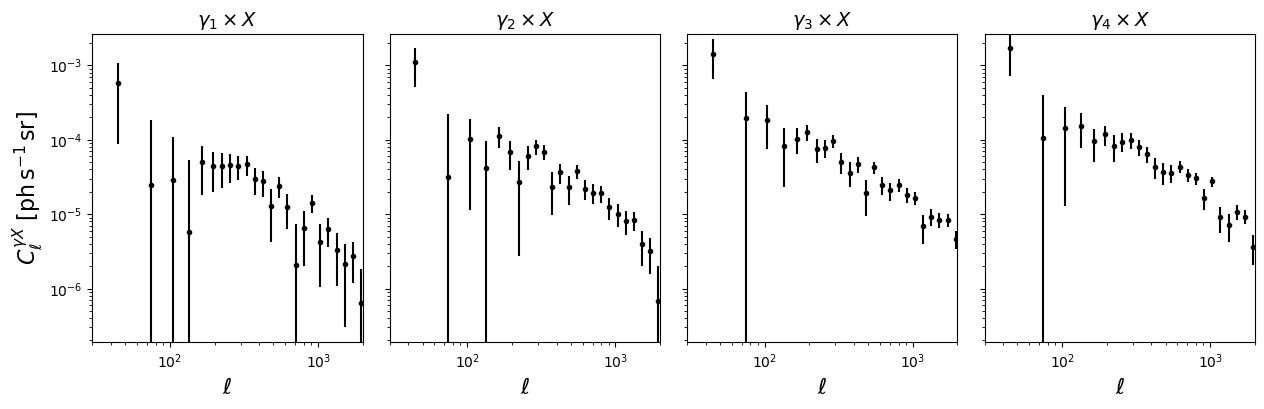

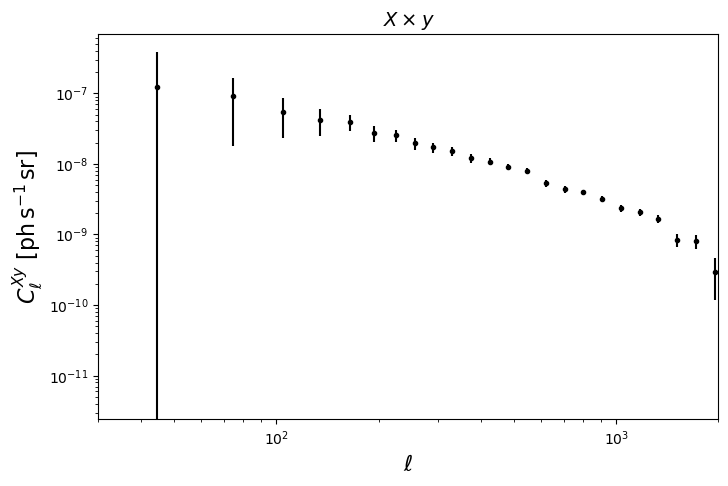

In [5]:
# gamma - y 
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

t1 = 'Planck__tSZ15'
for i in range(4):
    t2 = f'DESY3wl__{i}'
    ell, cl, cov = s.get_ell_cl('cl_0e', t1, t2, return_cov=True)
    ax = axes[i]
    ax.errorbar(ell, cl, yerr=np.sqrt(np.diag(cov)), fmt='k.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([30, 2000])
    ax.set_title(f'$\\gamma_{i+1} \\times y$', fontsize=14)
    ax.set_xlabel(r'$\ell$', fontsize=16)
axes[0].set_ylabel(r'$C^{\gamma y}_\ell$', fontsize=16);


# gamma - x
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

t1 = 'ROSAT'
for i in range(4):
    t2 = f'DESY3wl__{i}'
    ell, cl, cov = s.get_ell_cl('cl_0e', t1, t2, return_cov=True)
    ax = axes[i]
    ax.errorbar(ell, cl, yerr=np.sqrt(np.diag(cov)), fmt='k.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([30, 2000])
    ax.set_title(f'$\\gamma_{i+1} \\times X$', fontsize=14)
    ax.set_xlabel(r'$\ell$', fontsize=16)
axes[0].set_ylabel(r'$C^{\gamma X}_\ell\,\,[{\rm ph}\,{\rm s}^{-1}\,{\rm sr}]$', fontsize=16);

plt.figure(figsize=(8, 5))
t1 = 'ROSAT'
t2 = 'Planck__tSZ15'
ax = plt.gca()
ell, cl, cov = s.get_ell_cl('cl_00', t1, t2, return_cov=True)
ax.errorbar(ell, cl, yerr=np.sqrt(np.diag(cov)), fmt='k.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([30, 2000])
ax.set_title(f'$X \\times y$', fontsize=14)
ax.set_xlabel(r'$\ell$', fontsize=16)
ax.set_ylabel(r'$C^{Xy}_\ell\,\,[{\rm ph}\,{\rm s}^{-1}\,{\rm sr}]$', fontsize=16);

## 3.2 Bandpower window functions
In order to accurately compare these measurements against a given theory prediction, you also need the bandpower window functions of the measurements. These can also be extracted for each power spectrum.

Text(0, 0.5, '${\\cal F}_{q \\ell}$')

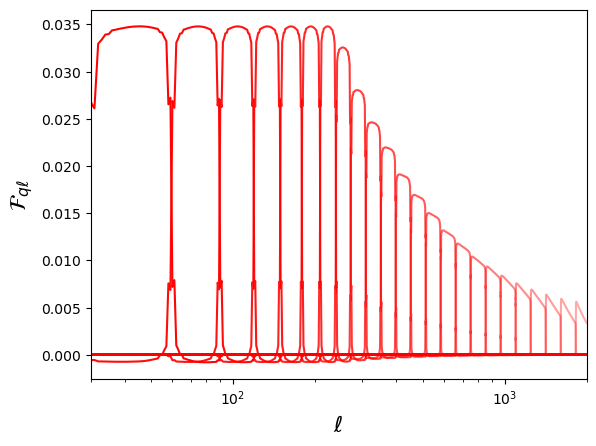

In [6]:
ell, cl, cov, ind = s.get_ell_cl('cl_0e', 'Planck__tSZ15', 'DESY3wl__2',
                                 return_cov=True, return_ind=True)
bpws = s.get_bandpower_windows(ind)

for i, bpw in enumerate(bpws.weight.T):
    alpha = 1 - 0.8*(i+0.5)/len(bpws.weight.T)
    plt.plot(bpws.values, bpw, 'r-', alpha=alpha)
plt.xlim([30, 2000])
plt.xscale('log')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'${\cal F}_{q \ell}$', fontsize=16)

## 3.3 Building a full data vector
Let's now look at the process of constructing a full data vector consisting of a set of power spectra. For example, we will collect all $\gamma \times y$ cross-correlations in addition to the $X\times y$ spectrum. We will then build the corresponding covariance matrix (in the right order) and inspect it.

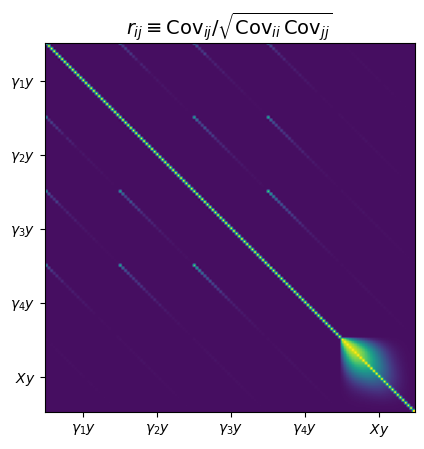

In [7]:
data_vec = []
indices = []
names = []

# gamma - y
for i in range(4):
    _, cl, ind = s.get_ell_cl('cl_0e', 'Planck__tSZ15', f'DESY3wl__{i}', return_ind=True)
    data_vec.append(cl)
    indices.append(ind)
    names.append(f'$\\gamma_{i+1} y$')

# X - y
_, cl, ind = s.get_ell_cl('cl_00', 'ROSAT', 'Planck__tSZ15', return_ind=True)
data_vec.append(cl)
indices.append(ind)
names.append(f'$X y$')

indices = np.concatenate(indices)
data_vec = np.concatenate(data_vec)

cov = (s.covariance.dense)[indices][:, indices]
r = cov / np.sqrt(np.outer(np.diag(cov), np.diag(cov)))
plt.figure()
ax = plt.gca()
ax.imshow(r)
tick_pos = np.linspace(0, len(data_vec), 6)
tick_pos = 0.5*(tick_pos[1:]+tick_pos[:-1])
ax.set_xticks(tick_pos)
ax.set_xticklabels(names)
ax.set_yticks(tick_pos)
ax.set_yticklabels(names)
ax.set_title(r'$r_{ij}\equiv {\rm Cov}_{ij}/\sqrt{{\rm Cov}_{ii}\,{\rm Cov}_{jj}}$', fontsize=14);